### Практическое задание

Обозначения:

p - глубина истории, сколько измерений назад учитываем в моделях

h - горизонт прогноза , на сколько измерений вперед смотрим при моделировании (как далеко предсказываем)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error

import os

In [2]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [3]:
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

#### 1. Прочитайте базу "Потребление Энергии" и сделайте модель для сезонных изменений по data_exp_1 с глубиной прогноза h=1 и h=10 по образцу из примера для обработки ряда "цена Нефти".

In [5]:
pjme_data = pd.read_csv('my_PJME_MW.csv', sep = ',', index_col=[0], parse_dates=[0])
pjme_data.head(2)

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0


In [6]:
pjme_data.describe().T

,count,mean,std,min,25%,50%,75%,max
PJME_MW,145374.0,32079.773047,6464.167501,14544.0,27573.0,31421.0,35648.75,62009.0
year,145374.0,2009.801340,4.791885,2002.0,2006.0,2010.0,2014.00,2018.0
month,145374.0,6.435979,3.438982,1.0,3.0,6.0,9.00,12.0
dayofmonth,145374.0,15.722681,8.801258,1.0,8.0,16.0,23.00,31.0
quarter,145374.0,2.481241,1.114448,1.0,1.0,2.0,3.00,4.0
dayofyear,145374.0,180.459835,105.138073,1.0,90.0,179.0,271.00,366.0
weekofyear,145374.0,26.218643,15.019836,1.0,13.0,26.0,39.00,53.0
dayofweek,145374.0,2.999168,1.999572,0.0,1.0,3.0,5.00,6.0
hour,145374.0,11.501101,6.921927,0.0,6.0,12.0,18.00,23.0
is_holiday,145374.0,0.027233,0.162763,0.0,0.0,0.0,0.00,1.0


Text(0.5, 0, 'Datte')

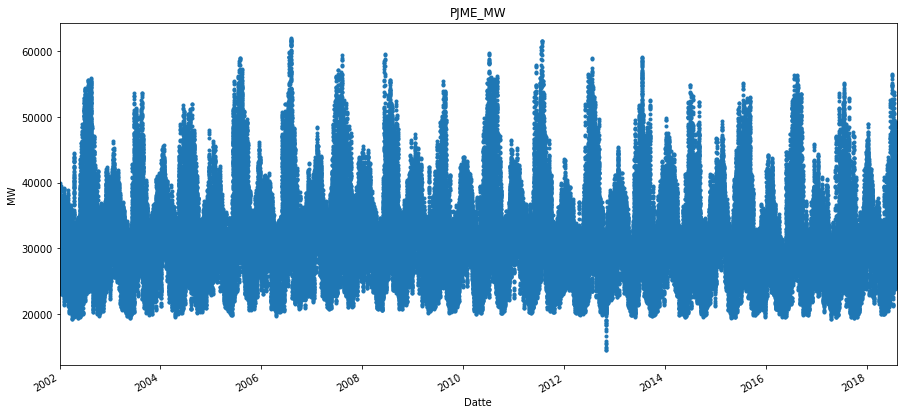

In [7]:
_ = pjme_data['PJME_MW'].plot(style='.', figsize=(15, 7), title='PJME_MW')
plt.ylabel('MW')
plt.xlabel('Datte')

In [8]:
pjme_data_m = pjme_data.resample('M').mean()

Text(0.5, 0, 't')

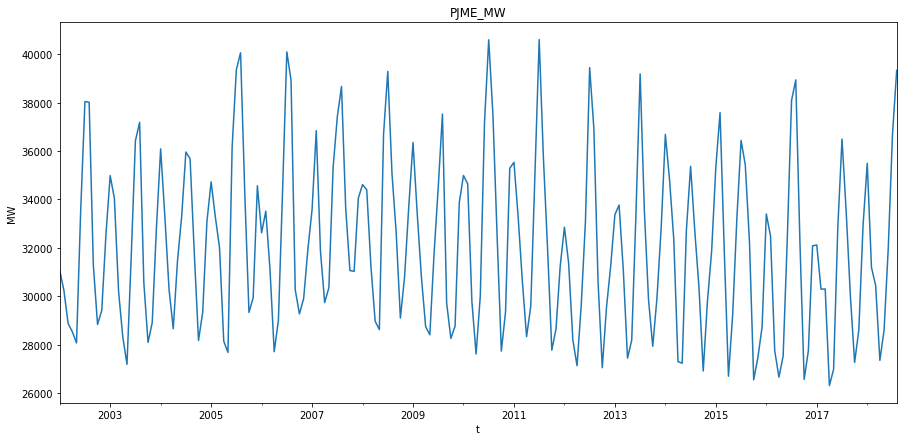

In [9]:
_ = pjme_data_m['PJME_MW'].plot(style='-', figsize=(15, 7), title='PJME_MW')
plt.ylabel('MW')
plt.xlabel('t')

In [10]:
pjme_data_d = pjme_data.resample('D').mean()

Text(0.5, 0, 't')

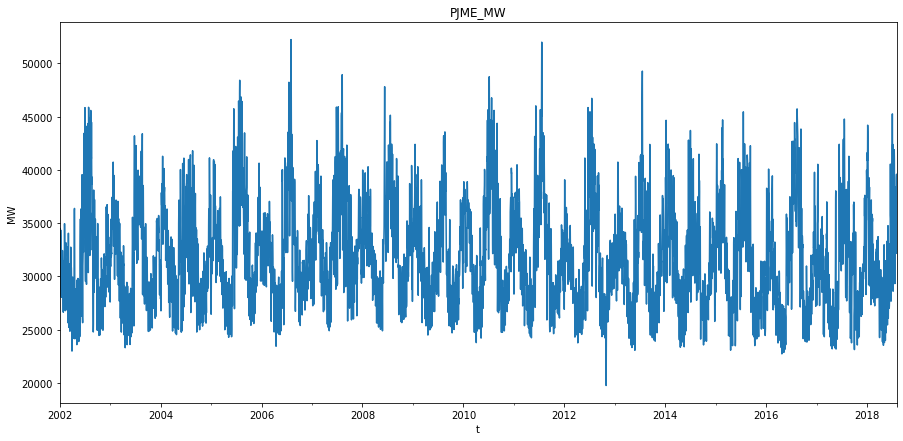

In [11]:
_ = pjme_data_d['PJME_MW'].plot(style='-', figsize=(15, 7), title='PJME_MW')
plt.ylabel('MW')
plt.xlabel('t')

Text(0.5, 1.0, 'PJME_MW')

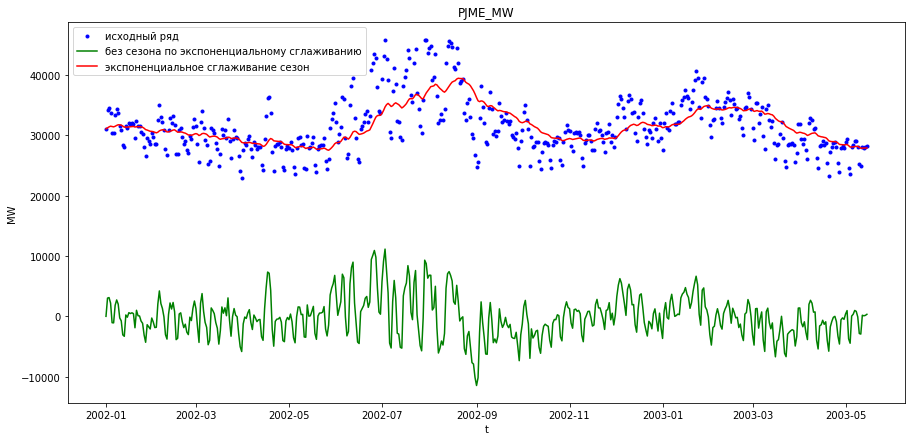

In [12]:
pjme_data_d_exp = exponential_smoothing(pjme_data_d['PJME_MW'], 0.05)

plt.figure(figsize=(15, 7))
plt.plot(pjme_data_d.index[:500], pjme_data_d['PJME_MW'].values[:500], '.b', label='исходный ряд')

plt.plot(pjme_data_d.index[:500], pjme_data_d['PJME_MW'].values[:500] - pjme_data_d_exp[:500], color='green', label="без сезона по экспоненциальному сглаживанию");

plt.plot(pjme_data_d.index[:500], pjme_data_d_exp[:500], color='red', label="экспоненциальное сглаживание сезон");

plt.xlabel('t')
plt.ylabel('MW')
plt.legend()
plt.title('PJME_MW')

In [13]:
df = pd.DataFrame({'value': pjme_data_d_exp}, index=pjme_data_d.index)

 # добавим историю на глубину 3 измерения от текущего (р=3)
df['lag_1'] = 0
df.iloc[1:, 1] = df.iloc[:-1, 0].values
df['lag_2'] = 0
df.iloc[2:, 2] = df.iloc[:-2, 0].values
df['lag_3'] = 0
df.iloc[3:, 3] = df.iloc[:-3, 0].values

# добавим сглаживание
df['exp_0_01'] = exponential_smoothing(df['value'], 0.01)
df['exp_0_05'] = exponential_smoothing(df['value'], 0.05)
df['exp_0_10'] = exponential_smoothing(df['value'], 0.10)

# добавим скользящее среднее 
df['ma_2'] = df['value'].rolling(2).mean().values
df['ma_3'] = df['value'].rolling(3).mean().values
df['ma_4'] = df['value'].rolling(4).mean().values

# добавим разности - 1-й порядок
df['diff_1'] = df['value'].diff()

# добавим разности - 2-й порядок
df['diff_2'] = df['diff_1'].diff()

df.fillna(0, inplace=True)

df.head(2)

,value,lag_1,lag_2,lag_3,exp_0_01,exp_0_05,exp_0_10,ma_2,ma_3,ma_4,diff_1,diff_2
Date,,,,,,,,,,,,
2002-01-01,31080.739130,0.00000,0.0,0.0,31080.739130,31080.739130,31080.739130,0.000000,0.0,0.0,0.000000,0.0
2002-01-02,31239.779257,31080.73913,0.0,0.0,31082.329532,31088.691137,31096.643143,31160.259194,0.0,0.0,159.040127,0.0


In [14]:
def split_data(data, index, split_date):
    return data.loc[data.index.get_level_values(index) <= split_date].copy(), \
           data.loc[data.index.get_level_values(index) >  split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:
train, test = split_data(df, 'Date', '30-09-2016')

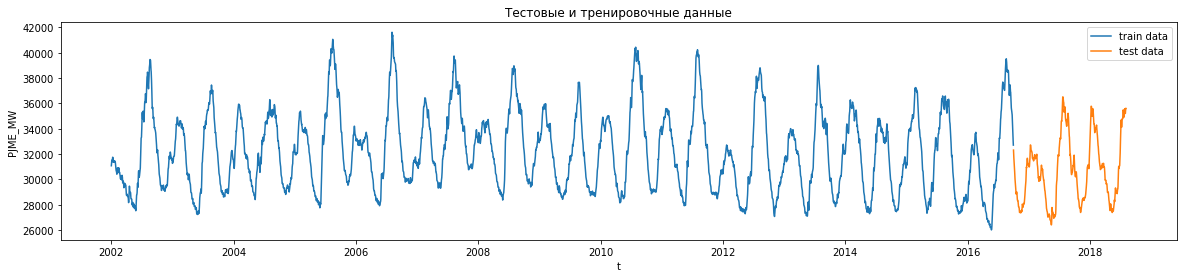

In [16]:
h = 1

X_train_1 = train.iloc[:-h, :]
y_train_1 = train['value'].values[h:]
X_test_1 = test.iloc[:-h, :]
y_test_1 = test['value'].values[h:]

plt.figure(figsize=(20, 4))
plt.xlabel('t')
plt.ylabel('PJME_MW')
plt.plot(train.index.get_level_values('Date'), train['value'], label='train data' )
plt.plot(test.index.get_level_values('Date'), test['value'], label='test data')
plt.title('Тестовые и тренировочные данные')
plt.legend()
plt.show()

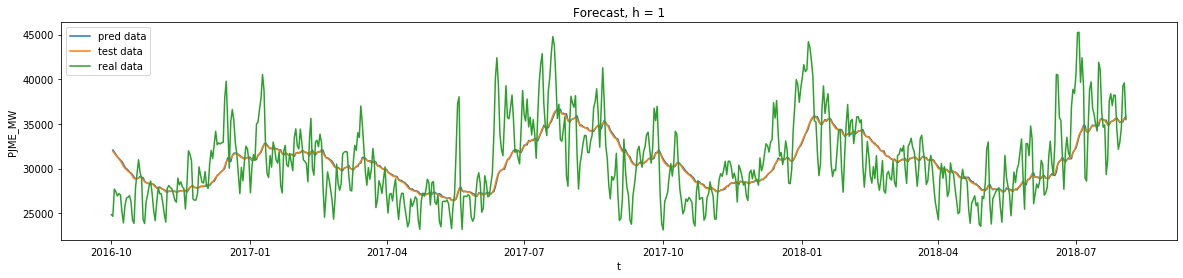

Mean absolute percantage error (h = 1): 0.3085%


In [17]:
model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)

model.fit(X_train_1, y_train_1) 

y_test_pred_1 = model.predict(X_test_1)

plt.figure(figsize=(20, 4))

plt.title('Forecast, h = 1')

plt.xlabel('t')
plt.ylabel('PJME_MW')
plt.plot(test.index[h:], y_test_pred_1, label='pred data')
plt.plot(test.index[h:], y_test_1, label='test data')
plt.plot(pjme_data_d.loc['2016-10-01':].index, pjme_data_d.loc['2016-10-01':]['PJME_MW'], label='real data')

plt.legend()
plt.show()

mape_1 = mean_absolute_percentage_error(y_true=y_test_1, y_pred=y_test_pred_1)

print(f'Mean absolute percantage error (h = 1): {np.round(mape_1, 4)}%')

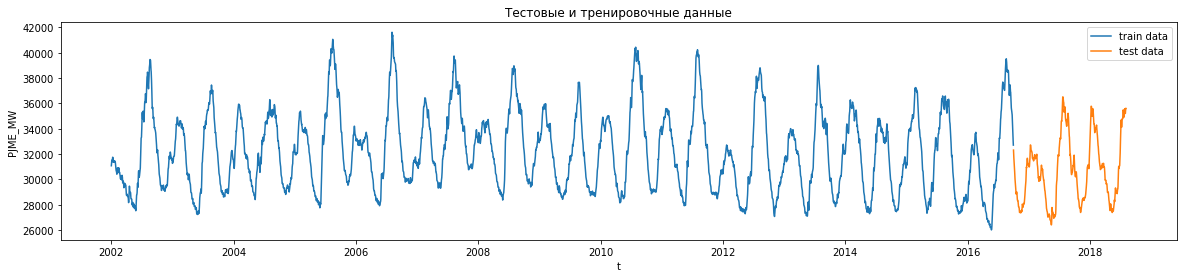

In [18]:
h = 10

X_train_10 = train.iloc[:-h, :]
y_train_10 = train['value'].values[h:]
X_test_10 = test.iloc[:-h, :]
y_test_10 = test['value'].values[h:]

plt.figure(figsize=(20, 4))
plt.xlabel('t')
plt.ylabel('PJME_MW')
plt.plot(train.index.get_level_values('Date'), train['value'], label='train data' )
plt.plot(test.index.get_level_values('Date'), test['value'], label='test data')
plt.title('Тестовые и тренировочные данные')
plt.legend()
plt.show()

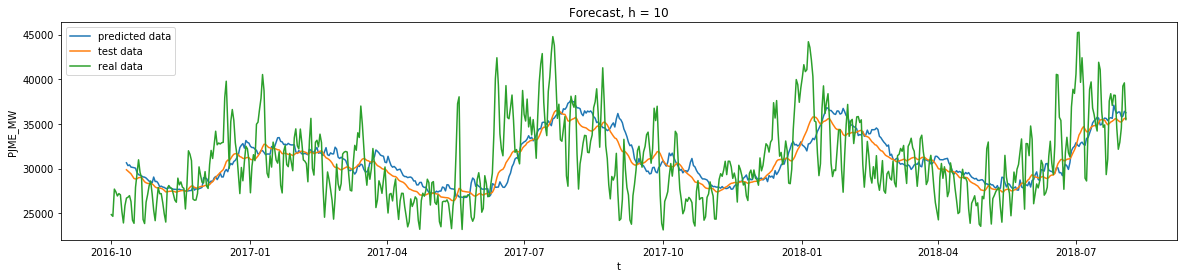

Mean absolute percantage error (h = 10): 2.5833%


In [19]:
model = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)

model.fit(X_train_10, y_train_10) 

y_test_pred_10 = model.predict(X_test_10)

plt.figure(figsize=(20, 4))

plt.title('Forecast, h = 10')

plt.xlabel('t')
plt.ylabel('PJME_MW')
plt.plot(test.index[h:], y_test_pred_10, label='predicted data')
plt.plot(test.index[h:], y_test_10, label='test data')
plt.plot(pjme_data_d.loc['2016-10-01':].index, pjme_data_d.loc['2016-10-01':]['PJME_MW'], label='real data')

plt.legend()
plt.show()

mape_10 = mean_absolute_percentage_error(y_true=y_test_10, y_pred=y_test_pred_10)

print(f'Mean absolute percantage error (h = 10): {np.round(mape_10, 4)}%')

#### 2. Оцените ошибку модели из п.1 .

In [20]:
mape_1 = mean_absolute_percentage_error(y_true=y_test_1, y_pred=y_test_pred_1)
mape_10 = mean_absolute_percentage_error(y_true=y_test_10, y_pred=y_test_pred_10)

print(f'Mean absolute percantage error (h = 1): {np.round(mape_1, 4)}%')
print(f'Mean absolute percantage error (h = 10): {np.round(mape_10, 4)}%')

Mean absolute percantage error (h = 1): 0.3085%
Mean absolute percantage error (h = 10): 2.5833%


#### 3. Сделайте вывод о том, как изменилась ошибка модели по значениям h.

При увеличении горизонта планирования с 1 дня вперед до 10 вперед, средняя абсолютная процентная ошибка, возрасла с 0.31% до 2.58%. Это логично, так как прогнозировать на большее кол-во времени вперед с такой же точностью, как на небольшое, достаточно трудно, если вообще возможно.

#### 4. Попробуйте предположить характер ряда (стационарный или нет, с трендом, с сезоном, с циклом) для рядов из списка и аргументируйте свой ответ (одна строка):

    а) Изменение температуры за окном :).
    
    б) Количество денег, которые тратят покупатели в интернет магазине.
    
    в) Вес растущего котенка.
    
    г) Прирост объема деревьев в лесу от времени

а) Изменение температуры за окном - стационарный ряд с циклом, экстремумы в январе и июле: температура зависит от времени года и так каждый год, при этом средняя температруа загод и ее разброс можно сичтать постоянными (не учитываю фактор глобального потепления и изменения погоды со временем, в таком случае в ряде появлется тренд и он уже не будет являться стационарным)

б) Количество денег, которые тратят покупатели в интернет магазине - нестационарный ряд с трендом и сезоонстью: траты покупателей зависят от общего состояния экономики (спрос растет или падает), сезона (сезонные товары, скидки и акции), поэтому нельзя говорить о постоянности мат ожидания и дисперсии

в) Вес растущего котенка - нестационарный ряд, с трендом: котенок растет и набирает вес достаточно быстро, затем к моменту взросления скорость набора веса замедляется и постепенно останавливается

г) Прирост объема деревьев в лесу от времени - нестационарный ряд с трендом: деревья растут медленно с течением времени, если исключить человеческий фактор (вырубка лесов), то объем деревьем на протяжении большого количества лет будет возрастать